####ResNet50 Image Classification Models

Load Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
import itertools
from tqdm import tqdm

!pip install split-folders
import splitfolders

from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import backend
from tensorflow.keras.optimizers import SGD, RMSprop
from keras.models import Sequential, Input, Model
from keras.layers import *

#https://blog.paperspace.com/improving-model-accuracy/
#!pip install tensorflow-hub
!git clone https://github.com/beringresearch/lrfinder/
!cd lrfinder && python3 -m pip install .
from lrfinder import LRFinder

from sklearn.metrics import confusion_matrix
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'lrfinder'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 54 (delta 12), reused 52 (delta 10), pack-reused 0
Unpacking objects: 100% (54/54), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/lrfinder
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for lrfinder: filename=lrfinder-0.1-py3-none-any.whl size=2486 sha256=3a2d04edf274816028171df488

Make Directories

In [ ]:
!mkdir /content/data

Download Data from Github

In [ ]:
# !sudo apt-get install git-lfs
%cd /content
!git clone https://github.com/MLDavies/ussian-mil-vehicles.git

!mkdir /content/datasets
!mkdir /content/datasets/data
!mv /content/ussian-mil-vehicles/russian-mil-vehicles-subsetA/* /content/datasets/data
!mv /content/ussian-mil-vehicles/russian-mil-vehicles-subsetB/* /content/datasets/data

splitfolders.ratio('/content/datasets/data', output="/content/datasets/vehicles", seed=1337, ratio=(.8, 0.1,0.1))

/content
Cloning into 'ussian-mil-vehicles'...
remote: Enumerating objects: 1035, done.
remote: Total 1035 (delta 0), reused 0 (delta 0), pack-reused 1035
Receiving objects: 100% (1035/1035), 293.04 MiB | 23.54 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Checking out files: 100% (1005/1005), done.


Copying files: 999 files [00:00, 2079.29 files/s]


Load & Visualize the Data

In [ ]:
datasets = ['/content/datasets/vehicles/train','/content/datasets/vehicles/test','/content/datasets/vehicles/val']

output = []

class_names = ['bm-21', 'bmd-2', 'bmp-1', 'bmp-2', 'btr-70', 'mt-lb', 't-72', 'btr-80', 't-64', 't-80']

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

nb_classes = len(class_names)
class_name_labels

{'bm-21': 0,
 'bmd-2': 1,
 'bmp-1': 2,
 'bmp-2': 3,
 'btr-70': 4,
 'btr-80': 7,
 'mt-lb': 5,
 't-64': 8,
 't-72': 6,
 't-80': 9}

In [ ]:
def load_data():
    for dataset in datasets:
        print("Loading {}".format(dataset))
        images,labels = [],[]

        for folder in os.listdir(dataset):
            label = class_name_labels[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                img_path = os.path.join(os.path.join(dataset,folder),file)
                img = cv2.imread(img_path,cv2.IMREAD_COLOR)
                img = cv2.resize(img,(224,224))

                images.append(img)
                labels.append(label)
                pass
            pass
        
        images = np.array(images,dtype=np.float32)
        labels = np.array(labels,dtype=np.float32)

        output.append((images,labels))
        pass

    return output
    pass

In [ ]:
(train_images,train_labels),(test_images,test_labels),(val_images,val_labels) = load_data()

Loading /content/datasets/vehicles/train


100%|██████████| 80/80 [00:01<00:00, 60.47it/s]


Loading /content/datasets/vehicles/test


100%|██████████| 10/10 [00:00<00:00, 16.60it/s]


Loading /content/datasets/vehicles/val


100%|██████████| 10/10 [00:00<00:00, 78.23it/s]


In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]
n_val = val_labels.shape[0]

_, train_count = np.unique(train_labels, return_counts=True)
_, test_count = np.unique(test_labels, return_counts=True)
_, val_count = np.unique(val_labels, return_counts=True)


df = pd.DataFrame(data = (train_count,test_count,val_count))
df = df.T
df['Index']=class_names
df.columns = ['Train','Test','Validation','Name']
df

,Train,Test,Validation,Name
0,80,10,10,bm-21
1,80,10,10,bmd-2
2,80,10,10,bmp-1
3,80,10,10,bmp-2
4,80,10,10,btr-70
5,79,11,9,mt-lb
6,80,10,10,t-72
7,80,10,10,btr-80
8,80,10,10,t-64
9,80,10,10,t-80


<Figure size 864x288 with 0 Axes>

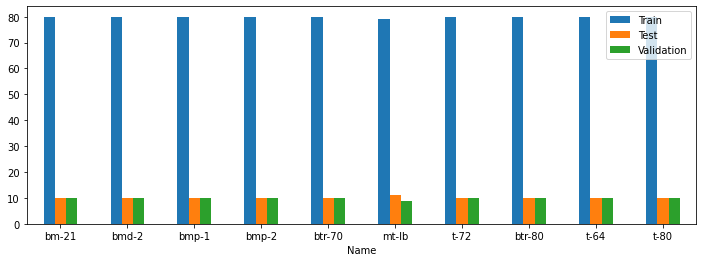

In [ ]:
plt.rcParams["figure.figsize"] = (12,4)
plt.figure()
df.set_index('Name').plot.bar(rot=0)

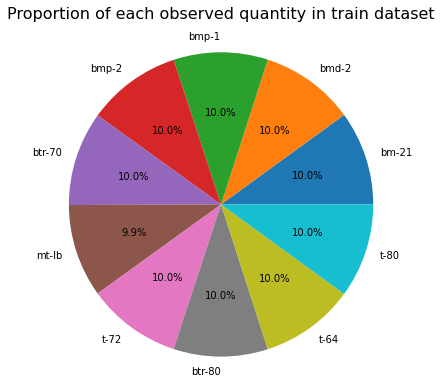

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)
plt.pie(train_count,
       explode=(0,0,0,0,0,0,0,0,0,0),
       labels = class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed quantity in train dataset', y=1.05, fontsize=16)
plt.show()

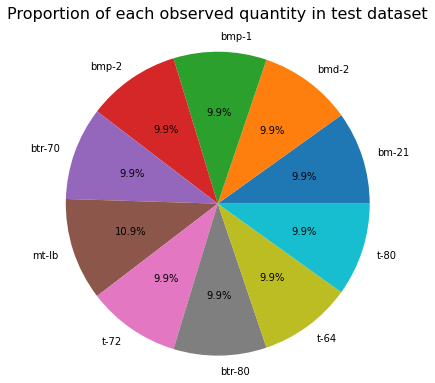

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)
plt.pie(test_count,
       explode=(0,0,0,0,0,0,0,0,0,0),
       labels = class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed quantity in test dataset', y=1.05, fontsize=16)
plt.show()

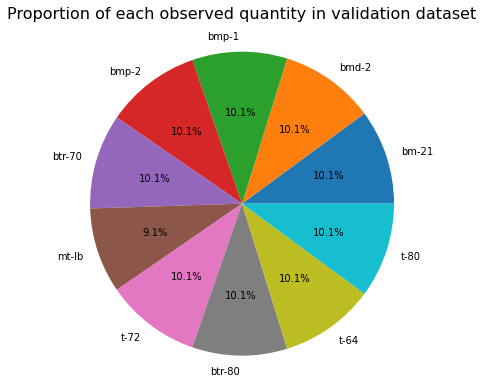

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)
plt.pie(val_count,
       explode=(0,0,0,0,0,0,0,0,0,0),
       labels = class_names,
       autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed quantity in validation dataset', y=1.05, fontsize=16)
plt.show()

Train, Test, and Validation Images

keras.ImageDataGenerator is used for making the train and test datasets. It allows for augmentation, dividing into batch size,shuffling without going through numpy and making large methods.

In [ ]:
train_dir = '/content/datasets/vehicles/train'
test_dir = '/content/datasets/vehicles/test' 
val_dir = '/content/datasets/vehicles/val' 
batch_size = 16
img_width = 224
img_height = 224

#Image Data Augmentation
IGD = ImageDataGenerator(rescale=1./255,        # normalize pixel values to [0,1]
                         shear_range=0.2,       # randomly applies shearing transformation
                         zoom_range=0.2,        # randomly applies shearing transformation
                         horizontal_flip=True)  # randomly flip the images

train_generator = IGD.flow_from_directory(train_dir,
                                         target_size=(img_width,img_height),
                                         color_mode='rgb',
                                         batch_size=batch_size,
                                         class_mode='sparse',
                                         shuffle=True,
                                         seed = 42)

test_generator = IGD.flow_from_directory(test_dir,
                                        target_size=(img_width,img_height),
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='sparse',
                                        shuffle=True,
                                        seed = 42)

val_generator = IGD.flow_from_directory(val_dir,
                                        target_size=(img_width,img_height),
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='sparse',
                                        shuffle=True,
                                        seed = 42)

Found 799 images belonging to 10 classes.
Found 101 images belonging to 10 classes.
Found 99 images belonging to 10 classes.


In [ ]:
nb_classes = len(train_generator.class_indices)
nb_classes

10

Confusion Matrix Method

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

Base Model: ResNet50 - pretrained model with ImageNet using SGD optimizer

In [ ]:
base_model_resnet = ResNet50(include_top=False,
                             weights='imagenet',
                             input_shape=(img_width,
                                          img_height,
                                          3)
                             )

94781440/94765736 [==============================] - 4s 0us/step


In [ ]:
x = base_model_resnet.output
x = Flatten(name="flatten")(x)
output_layer = Dense(nb_classes, activation='softmax')(x)
model_resnet = Model(inputs=base_model_resnet.input, outputs=output_layer)

In [ ]:
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model_resnet.compile(optimizer=SGD(), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
K = tf.keras.backend

STEPS_PER_EPOCH = np.ceil(train_images.shape[0] / batch_size)
lr_finder = LRFinder(model_resnet)
lr_finder.find(train_generator, start_lr=1e-6, end_lr=1, epochs=50,
               steps_per_epoch=STEPS_PER_EPOCH)
               
learning_rates = lr_finder.get_learning_rates()
losses = lr_finder.get_losses()

best_lr = lr_finder.get_best_lr(sma=20)

# Setting it as our model's LR through Keras Backend
K.set_value(model_resnet.optimizer.lr, best_lr)
print("Best Learning Rate: ", best_lr)

Epoch 1/50
50/50 [==============================] - 36s 418ms/step - loss: 3.7314 - accuracy: 0.1214
Epoch 2/50
50/50 [==============================] - 22s 439ms/step - loss: 3.5753 - accuracy: 0.1364
Epoch 3/50
50/50 [==============================] - 22s 432ms/step - loss: 3.7099 - accuracy: 0.1239
Epoch 4/50
50/50 [==============================] - 21s 422ms/step - loss: 3.5585 - accuracy: 0.1364
Epoch 5/50
50/50 [==============================] - 22s 440ms/step - loss: 3.4869 - accuracy: 0.1402
Epoch 6/50
50/50 [==============================] - 21s 423ms/step - loss: 3.3297 - accuracy: 0.1176
Epoch 7/50
50/50 [==============================] - 21s 423ms/step - loss: 3.3324 - accuracy: 0.1452
Epoch 8/50
50/50 [==============================] - 22s 430ms/step - loss: 3.2206 - accuracy: 0.1414
Epoch 9/50
50/50 [==============================] - 22s 444ms/step - loss: 3.1143 - accuracy: 0.1752
Epoch 10/50
50/50 [==============================] - 21s 424ms/step - loss: 2.8995 - accura

In [ ]:
model_resnet.compile(optimizer=SGD(best_lr), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
epochs = 100

history = model_resnet.fit(train_generator,
                                epochs=epochs,
                                validation_data=val_generator,
                                steps_per_epoch=train_images.shape[0] // batch_size,
                                validation_steps=val_images.shape[0] // batch_size,
                                verbose=1)

Epoch 1/100
49/49 [==============================] - 28s 491ms/step - loss: 3.7375 - accuracy: 0.0995 - val_loss: 2.7588 - val_accuracy: 0.1042
Epoch 2/100
49/49 [==============================] - 23s 473ms/step - loss: 3.5174 - accuracy: 0.1226 - val_loss: 2.6091 - val_accuracy: 0.1042
Epoch 3/100
49/49 [==============================] - 24s 489ms/step - loss: 3.5380 - accuracy: 0.1239 - val_loss: 2.5816 - val_accuracy: 0.1042
Epoch 4/100
49/49 [==============================] - 23s 470ms/step - loss: 3.3983 - accuracy: 0.1277 - val_loss: 2.8031 - val_accuracy: 0.0938
Epoch 5/100
49/49 [==============================] - 24s 493ms/step - loss: 3.3651 - accuracy: 0.1226 - val_loss: 2.8713 - val_accuracy: 0.1146
Epoch 6/100
49/49 [==============================] - 23s 476ms/step - loss: 3.2627 - accuracy: 0.1430 - val_loss: 2.9569 - val_accuracy: 0.1146
Epoch 7/100
49/49 [==============================] - 23s 474ms/step - loss: 3.2588 - accuracy: 0.1405 - val_loss: 3.0242 - val_accuracy:

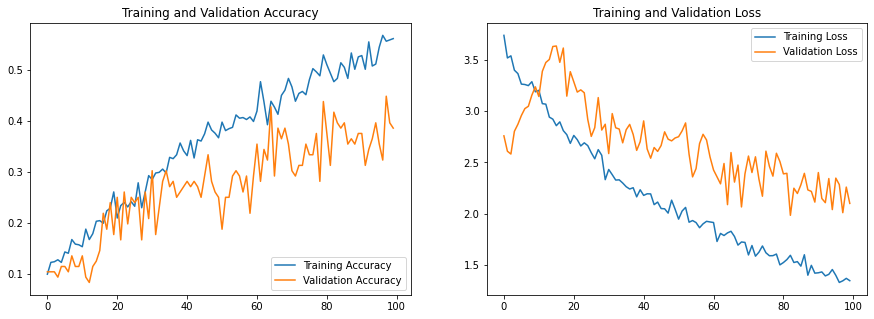

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<Figure size 432x432 with 0 Axes>

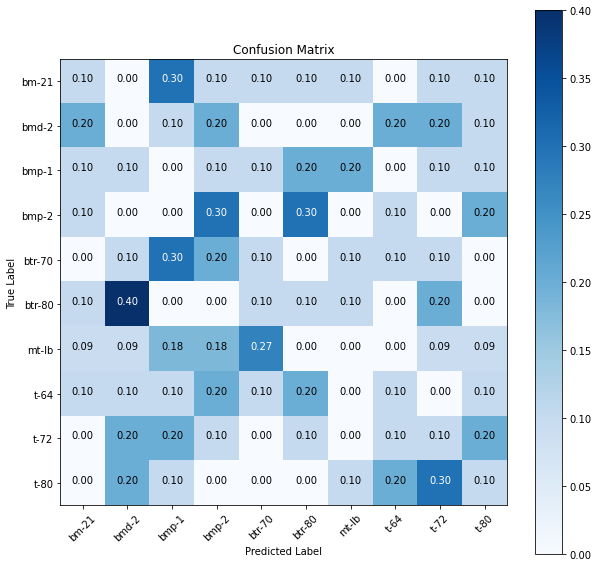

In [ ]:
test_pred = model_resnet.predict(test_generator)
y_pred = [np.argmax(probas) for probas in test_pred]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names)
plt.show()

In [ ]:
model_resnet.evaluate(test_generator)

7/7 [==============================] - 3s 441ms/step - loss: 2.0806 - accuracy: 0.3663


[2.080638885498047, 0.3663366436958313]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.10      0.11        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.21      0.30      0.25        10
           4       0.12      0.10      0.11        10
           5       0.10      0.10      0.10        10
           6       0.00      0.00      0.00        11
           7       0.12      0.10      0.11        10
           8       0.08      0.10      0.09        10
           9       0.10      0.10      0.10        10

    accuracy                           0.09       101
   macro avg       0.09      0.09      0.09       101
weighted avg       0.09      0.09      0.09       101



Base Model: ResNet50 - pretrained model with ImageNet using using RMSprop


In [ ]:
base_model_resnet = ResNet50(include_top=False,
                             weights='imagenet',
                             input_shape=(img_width,
                                          img_height,
                                          3)
                             )

In [ ]:
x = base_model_resnet.output
x = Flatten(name="flatten")(x)
output_layer = Dense(nb_classes, activation='softmax')(x)
model_resnet = Model(inputs=base_model_resnet.input, outputs=output_layer)

In [ ]:
model_resnet.compile(optimizer=RMSprop(), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
K = tf.keras.backend

STEPS_PER_EPOCH = np.ceil(train_images.shape[0] / batch_size)
lr_finder = LRFinder(model_resnet)
lr_finder.find(train_generator, start_lr=1e-6, end_lr=1, epochs=50,
               steps_per_epoch=STEPS_PER_EPOCH)
               
learning_rates = lr_finder.get_learning_rates()
losses = lr_finder.get_losses()

# sma: number of batches for simple moving average to smooth out the curve.
best_lr = lr_finder.get_best_lr(sma=20)

# Setting it as our model's LR through Keras Backend
K.set_value(model_resnet.optimizer.lr, best_lr)
print("Best Learning Rate: ", best_lr)

Epoch 1/50
50/50 [==============================] - 39s 378ms/step - loss: 3.8855 - accuracy: 0.1039
Epoch 2/50
50/50 [==============================] - 21s 410ms/step - loss: 3.6493 - accuracy: 0.1176
Epoch 3/50
50/50 [==============================] - 19s 380ms/step - loss: 3.2691 - accuracy: 0.1539
Epoch 4/50
50/50 [==============================] - 20s 389ms/step - loss: 3.0168 - accuracy: 0.1990
Epoch 5/50
50/50 [==============================] - 19s 383ms/step - loss: 2.8084 - accuracy: 0.2028
Epoch 6/50
50/50 [==============================] - 19s 383ms/step - loss: 2.4066 - accuracy: 0.3204
Epoch 7/50
50/50 [==============================] - 19s 388ms/step - loss: 2.1019 - accuracy: 0.3767
Epoch 8/50
50/50 [==============================] - 19s 379ms/step - loss: 1.7491 - accuracy: 0.4443
Epoch 9/50
50/50 [==============================] - 19s 384ms/step - loss: 1.3337 - accuracy: 0.5707
Epoch 10/50
50/50 [==============================] - 21s 419ms/step - loss: 0.9599 - accura

In [ ]:
model_resnet.compile(optimizer=RMSprop(best_lr), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
epochs = 100

history = model_resnet.fit(train_generator,
                           epochs=epochs,
                           validation_data=val_generator,
                           steps_per_epoch=train_images.shape[0] // batch_size,
                           validation_steps=val_images.shape[0] // batch_size,
                           verbose=1)

Epoch 1/100
49/49 [==============================] - 32s 456ms/step - loss: 3.7174 - accuracy: 0.1175 - val_loss: 2.5203 - val_accuracy: 0.0938
Epoch 2/100
49/49 [==============================] - 22s 447ms/step - loss: 3.1030 - accuracy: 0.1954 - val_loss: 2.5935 - val_accuracy: 0.1146
Epoch 3/100
49/49 [==============================] - 21s 421ms/step - loss: 2.8354 - accuracy: 0.2273 - val_loss: 2.8915 - val_accuracy: 0.1146
Epoch 4/100
49/49 [==============================] - 21s 431ms/step - loss: 2.5496 - accuracy: 0.2516 - val_loss: 3.1454 - val_accuracy: 0.0938
Epoch 5/100
49/49 [==============================] - 21s 425ms/step - loss: 2.1914 - accuracy: 0.3487 - val_loss: 3.2687 - val_accuracy: 0.1146
Epoch 6/100
49/49 [==============================] - 21s 425ms/step - loss: 1.9893 - accuracy: 0.3729 - val_loss: 3.2637 - val_accuracy: 0.0833
Epoch 7/100
49/49 [==============================] - 21s 424ms/step - loss: 1.8128 - accuracy: 0.4330 - val_loss: 3.0829 - val_accuracy:

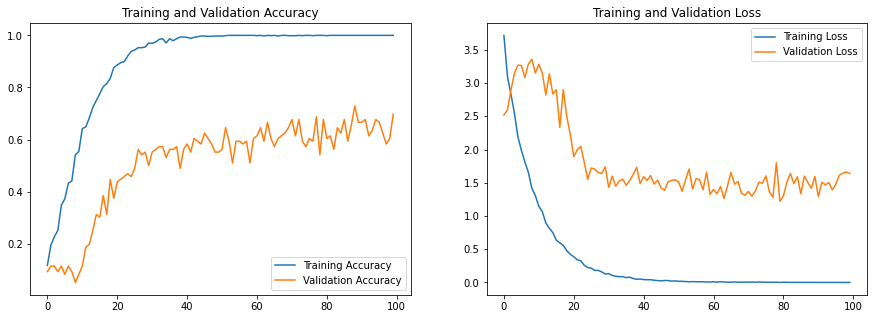

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

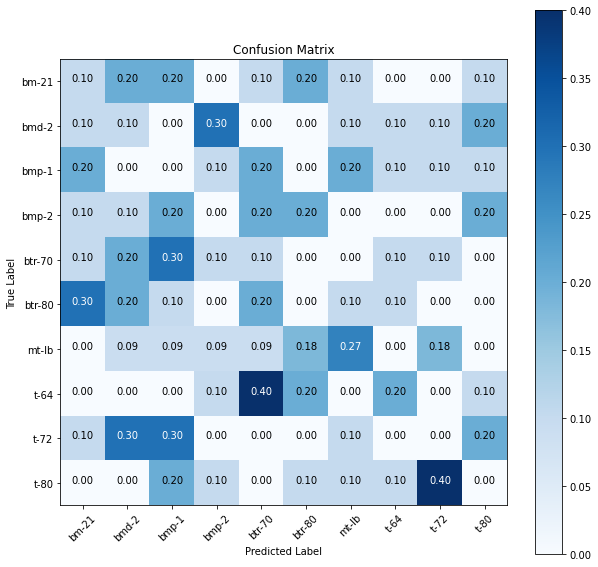

In [ ]:
test_pred = model_resnet.predict(test_generator)
y_pred = [np.argmax(probas) for probas in test_pred]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names)
plt.show()

In [ ]:
model_resnet.evaluate(test_generator)

7/7 [==============================] - 3s 421ms/step - loss: 1.3391 - accuracy: 0.6436


[1.3390908241271973, 0.6435643434524536]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.10      0.10      0.10        10
           1       0.08      0.10      0.09        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.08      0.10      0.09        10
           5       0.00      0.00      0.00        10
           6       0.30      0.27      0.29        11
           7       0.29      0.20      0.24        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.08       101
   macro avg       0.08      0.08      0.08       101
weighted avg       0.09      0.08      0.08       101



ResNet50 

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with ResNet50 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    x = model_resnet.output
    x = BatchNormalization()(x)
    x = Dense(256, activation ='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation ='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation ='relu')(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_classes, activation='softmax')(x)
      
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in model_resnet.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in model_resnet.layers:
            layer.trainable = False

    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=model_resnet.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (224, 224, 3)
optim = RMSprop()
num_classes=10

# leaving all the layers frozen for Fine-Tuning
model = create_model(input_shape, num_classes, optim, fine_tune=0)

In [ ]:
K = tf.keras.backend

STEPS_PER_EPOCH = np.ceil(train_images.shape[0] / batch_size)
lr_finder = LRFinder(model)
lr_finder.find(train_generator, start_lr=1e-6, end_lr=1, epochs=50,
               steps_per_epoch=STEPS_PER_EPOCH)
               
learning_rates = lr_finder.get_learning_rates()
losses = lr_finder.get_losses()

best_lr = lr_finder.get_best_lr(sma=20)

# Setting it as our model's LR through Keras Backend
K.set_value(model.optimizer.lr, best_lr)
print("Best Learning Rate: ", best_lr)

Epoch 1/50
50/50 [==============================] - 23s 372ms/step - loss: 3.2341 - accuracy: 0.0839
Epoch 2/50
50/50 [==============================] - 19s 375ms/step - loss: 3.1788 - accuracy: 0.1039
Epoch 3/50
50/50 [==============================] - 19s 382ms/step - loss: 3.1736 - accuracy: 0.0901
Epoch 4/50
50/50 [==============================] - 19s 378ms/step - loss: 3.1470 - accuracy: 0.0901
Epoch 5/50
50/50 [==============================] - 19s 374ms/step - loss: 3.1557 - accuracy: 0.0713
Epoch 6/50
50/50 [==============================] - 19s 382ms/step - loss: 3.0708 - accuracy: 0.1026
Epoch 7/50
50/50 [==============================] - 19s 377ms/step - loss: 3.0808 - accuracy: 0.1114
Epoch 8/50
50/50 [==============================] - 19s 377ms/step - loss: 2.9681 - accuracy: 0.1114
Epoch 9/50
50/50 [==============================] - 19s 376ms/step - loss: 2.9076 - accuracy: 0.1114
Epoch 10/50
50/50 [==============================] - 19s 377ms/step - loss: 2.9150 - accura

In [ ]:
model.compile(optimizer=RMSprop(best_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 100

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    steps_per_epoch=train_images.shape[0] // batch_size,
                    validation_steps=val_images.shape[0] // batch_size,
                    verbose=1)

Epoch 1/100
49/49 [==============================] - 25s 442ms/step - loss: 3.1870 - accuracy: 0.0894 - val_loss: 2.3431 - val_accuracy: 0.0625
Epoch 2/100
49/49 [==============================] - 20s 416ms/step - loss: 3.1254 - accuracy: 0.1149 - val_loss: 2.3993 - val_accuracy: 0.0833
Epoch 3/100
49/49 [==============================] - 20s 415ms/step - loss: 3.0091 - accuracy: 0.1111 - val_loss: 2.4267 - val_accuracy: 0.0104
Epoch 4/100
49/49 [==============================] - 20s 419ms/step - loss: 2.9348 - accuracy: 0.1264 - val_loss: 2.4650 - val_accuracy: 0.0208
Epoch 5/100
49/49 [==============================] - 21s 419ms/step - loss: 2.9318 - accuracy: 0.1252 - val_loss: 2.5102 - val_accuracy: 0.0417
Epoch 6/100
49/49 [==============================] - 20s 416ms/step - loss: 2.8598 - accuracy: 0.1341 - val_loss: 2.4829 - val_accuracy: 0.2083
Epoch 7/100
49/49 [==============================] - 20s 416ms/step - loss: 2.8954 - accuracy: 0.1239 - val_loss: 2.4454 - val_accuracy:

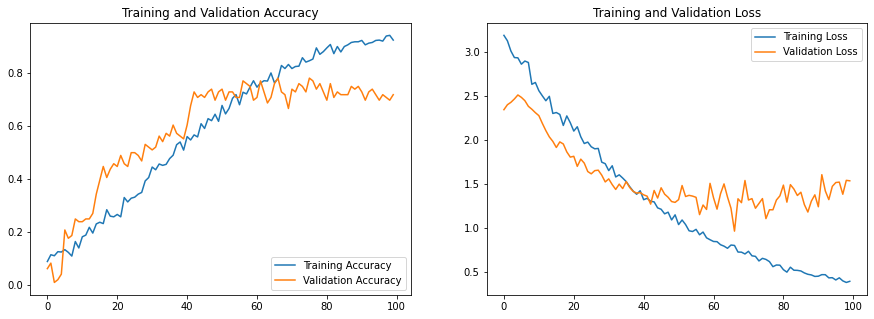

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

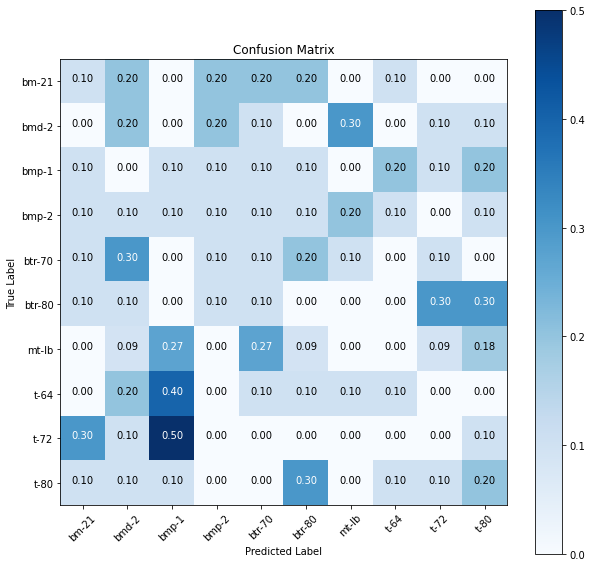

In [ ]:
test_pred = model.predict(test_generator)
y_pred = [np.argmax(probas) for probas in test_pred]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names)
plt.show()

In [ ]:
model.evaluate(test_generator)

7/7 [==============================] - 3s 422ms/step - loss: 1.7088 - accuracy: 0.6535


[1.7087984085083008, 0.6534653306007385]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.11      0.10      0.11        10
           1       0.14      0.20      0.17        10
           2       0.07      0.10      0.08        10
           3       0.12      0.10      0.11        10
           4       0.09      0.10      0.10        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        11
           7       0.17      0.10      0.12        10
           8       0.00      0.00      0.00        10
           9       0.17      0.20      0.18        10

    accuracy                           0.09       101
   macro avg       0.09      0.09      0.09       101
weighted avg       0.09      0.09      0.09       101



next model 

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with ResNet50 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    x = model_resnet.output
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x) 
    x = Dense(128, activation ='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation ='relu')(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_classes, activation='softmax')(x)
      
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in model_resnet.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in model_resnet.layers:
            layer.trainable = False

    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=model_resnet.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (224, 224, 3)
optim = RMSprop()
num_classes=10

# No layers unfrozen for Fine-Tuning
model = create_model(input_shape, num_classes, optim, fine_tune=0)

In [ ]:
K = tf.keras.backend

STEPS_PER_EPOCH = np.ceil(train_images.shape[0] / batch_size)
lr_finder = LRFinder(model)
lr_finder.find(train_generator, start_lr=1e-6, end_lr=1, epochs=50,
               steps_per_epoch=STEPS_PER_EPOCH)
               
learning_rates = lr_finder.get_learning_rates()
losses = lr_finder.get_losses()

best_lr = lr_finder.get_best_lr(sma=20)

# Setting it as our model's LR through Keras Backend
K.set_value(model.optimizer.lr, best_lr)
print("Best Learning Rate: ", best_lr)

Epoch 1/50
50/50 [==============================] - 22s 380ms/step - loss: 2.9654 - accuracy: 0.0788
Epoch 2/50
50/50 [==============================] - 19s 379ms/step - loss: 2.9451 - accuracy: 0.0851
Epoch 3/50
50/50 [==============================] - 19s 378ms/step - loss: 2.9128 - accuracy: 0.0914
Epoch 4/50
50/50 [==============================] - 19s 378ms/step - loss: 2.9874 - accuracy: 0.0713
Epoch 5/50
50/50 [==============================] - 19s 377ms/step - loss: 2.8912 - accuracy: 0.1101
Epoch 6/50
50/50 [==============================] - 19s 379ms/step - loss: 2.8796 - accuracy: 0.0976
Epoch 7/50
50/50 [==============================] - 19s 379ms/step - loss: 2.8485 - accuracy: 0.0926
Epoch 8/50
50/50 [==============================] - 19s 371ms/step - loss: 2.8174 - accuracy: 0.1202
Epoch 9/50
50/50 [==============================] - 19s 377ms/step - loss: 2.8505 - accuracy: 0.0901
Epoch 10/50
50/50 [==============================] - 19s 376ms/step - loss: 2.9128 - accura

In [ ]:
model.compile(optimizer=RMSprop(best_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 100

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    steps_per_epoch=train_images.shape[0] // batch_size,
                    validation_steps=val_images.shape[0] // batch_size,
                    verbose=1)

Epoch 1/100
49/49 [==============================] - 25s 444ms/step - loss: 1.3638 - accuracy: 0.5722 - val_loss: 1.2479 - val_accuracy: 0.7396
Epoch 2/100
49/49 [==============================] - 21s 425ms/step - loss: 1.1589 - accuracy: 0.5964 - val_loss: 1.2064 - val_accuracy: 0.7396
Epoch 3/100
49/49 [==============================] - 21s 424ms/step - loss: 1.1358 - accuracy: 0.6143 - val_loss: 1.1277 - val_accuracy: 0.7708
Epoch 4/100
49/49 [==============================] - 21s 432ms/step - loss: 1.1105 - accuracy: 0.6015 - val_loss: 1.1741 - val_accuracy: 0.8021
Epoch 5/100
49/49 [==============================] - 21s 426ms/step - loss: 1.1284 - accuracy: 0.6186 - val_loss: 1.7709 - val_accuracy: 0.7396
Epoch 6/100
49/49 [==============================] - 21s 423ms/step - loss: 1.1336 - accuracy: 0.6143 - val_loss: 1.7270 - val_accuracy: 0.7188
Epoch 7/100
49/49 [==============================] - 21s 423ms/step - loss: 1.0556 - accuracy: 0.6424 - val_loss: 1.8832 - val_accuracy:

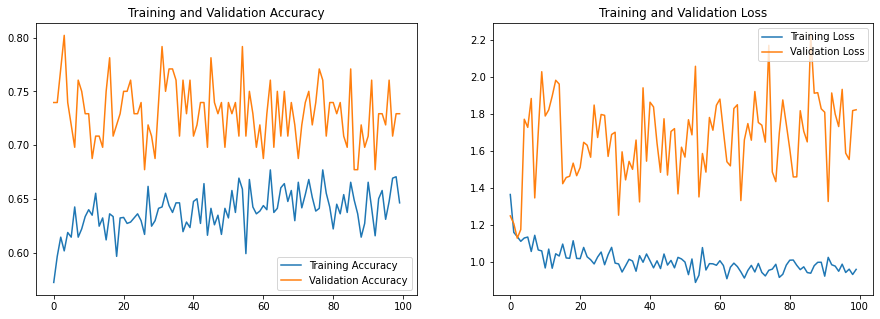

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

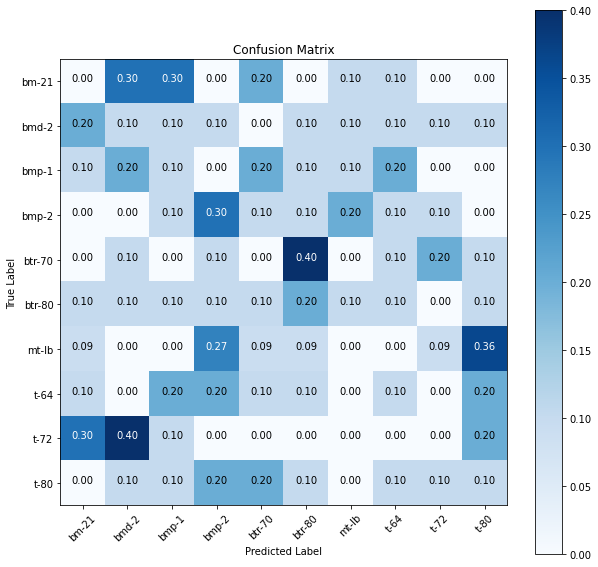

In [ ]:
test_pred = model.predict(test_generator)
y_pred = [np.argmax(probas) for probas in test_pred]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names)
plt.show()

In [ ]:
model.evaluate(test_generator)

7/7 [==============================] - 3s 419ms/step - loss: 2.0844 - accuracy: 0.6832


[2.084350347518921, 0.6831682920455933]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.08      0.10      0.09        10
           2       0.09      0.10      0.10        10
           3       0.23      0.30      0.26        10
           4       0.00      0.00      0.00        10
           5       0.17      0.20      0.18        10
           6       0.00      0.00      0.00        11
           7       0.11      0.10      0.11        10
           8       0.00      0.00      0.00        10
           9       0.08      0.10      0.09        10

    accuracy                           0.09       101
   macro avg       0.08      0.09      0.08       101
weighted avg       0.08      0.09      0.08       101



model 3

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with ResNet50 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    x = model_resnet.output
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x) 
    x = Dense(64, activation ='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation ='relu')(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_classes, activation='softmax')(x)
      
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in model_resnet.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in model_resnet.layers:
            layer.trainable = False

    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=model_resnet.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (224, 224, 3)
optim = RMSprop()
num_classes=10

# No layers unfrozen for Fine-Tuning
model = create_model(input_shape, num_classes, optim, fine_tune=0)

In [ ]:
K = tf.keras.backend

STEPS_PER_EPOCH = np.ceil(train_images.shape[0] / batch_size)
lr_finder = LRFinder(model)
lr_finder.find(train_generator, start_lr=1e-6, end_lr=1, epochs=50,
               steps_per_epoch=STEPS_PER_EPOCH)
               
learning_rates = lr_finder.get_learning_rates()
losses = lr_finder.get_losses()

best_lr = lr_finder.get_best_lr(sma=20)

# Setting it as our model's LR through Keras Backend
K.set_value(model.optimizer.lr, best_lr)
print("Best Learning Rate: ", best_lr)

Epoch 1/50
50/50 [==============================] - 22s 375ms/step - loss: 2.7285 - accuracy: 0.1314
Epoch 2/50
50/50 [==============================] - 19s 376ms/step - loss: 2.7995 - accuracy: 0.1239
Epoch 3/50
50/50 [==============================] - 19s 380ms/step - loss: 2.7235 - accuracy: 0.1277
Epoch 4/50
50/50 [==============================] - 19s 374ms/step - loss: 2.7322 - accuracy: 0.1402
Epoch 5/50
50/50 [==============================] - 19s 378ms/step - loss: 2.7321 - accuracy: 0.1277
Epoch 6/50
50/50 [==============================] - 19s 375ms/step - loss: 2.7266 - accuracy: 0.1176
Epoch 7/50
50/50 [==============================] - 19s 377ms/step - loss: 2.7053 - accuracy: 0.1252
Epoch 8/50
50/50 [==============================] - 19s 375ms/step - loss: 2.7663 - accuracy: 0.1339
Epoch 9/50
50/50 [==============================] - 19s 374ms/step - loss: 2.7198 - accuracy: 0.1389
Epoch 10/50
50/50 [==============================] - 19s 377ms/step - loss: 2.6727 - accura

In [ ]:
model.compile(optimizer=RMSprop(best_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 100

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    steps_per_epoch=train_images.shape[0] // batch_size,
                    validation_steps=val_images.shape[0] // batch_size,
                    verbose=1)

Epoch 1/100
49/49 [==============================] - 25s 449ms/step - loss: 2.0205 - accuracy: 0.4176 - val_loss: 1.5378 - val_accuracy: 0.6771
Epoch 2/100
49/49 [==============================] - 21s 421ms/step - loss: 1.6296 - accuracy: 0.4968 - val_loss: 1.5282 - val_accuracy: 0.7292
Epoch 3/100
49/49 [==============================] - 21s 423ms/step - loss: 1.4403 - accuracy: 0.5581 - val_loss: 1.4949 - val_accuracy: 0.7188
Epoch 4/100
49/49 [==============================] - 21s 416ms/step - loss: 1.4595 - accuracy: 0.5670 - val_loss: 1.4585 - val_accuracy: 0.7708
Epoch 5/100
49/49 [==============================] - 21s 420ms/step - loss: 1.3792 - accuracy: 0.5632 - val_loss: 1.8940 - val_accuracy: 0.7812
Epoch 6/100
49/49 [==============================] - 21s 424ms/step - loss: 1.5168 - accuracy: 0.5300 - val_loss: 1.8157 - val_accuracy: 0.7292
Epoch 7/100
49/49 [==============================] - 20s 418ms/step - loss: 1.4213 - accuracy: 0.5734 - val_loss: 2.2222 - val_accuracy:

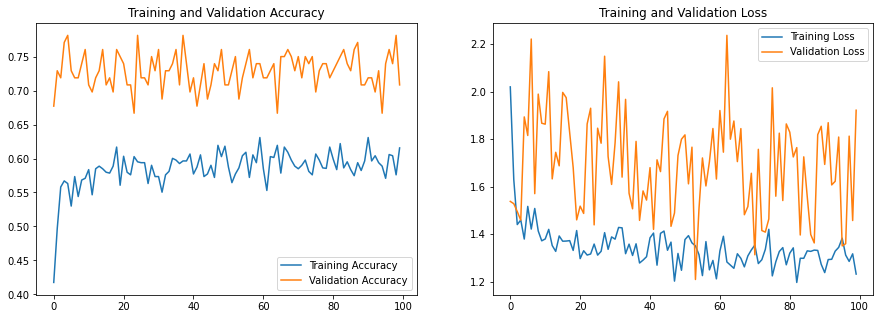

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

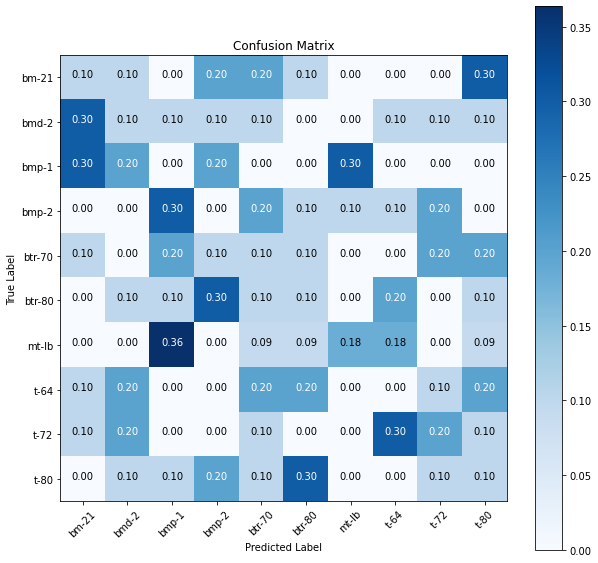

In [ ]:
test_pred = model.predict(test_generator)
y_pred = [np.argmax(probas) for probas in test_pred]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names)
plt.show()

In [ ]:
model.evaluate(test_generator)

7/7 [==============================] - 3s 392ms/step - loss: 1.9154 - accuracy: 0.6733


[1.9154194593429565, 0.6732673048973083]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.10      0.10      0.10        10
           1       0.10      0.10      0.10        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.08      0.10      0.09        10
           5       0.10      0.10      0.10        10
           6       0.33      0.18      0.24        11
           7       0.00      0.00      0.00        10
           8       0.22      0.20      0.21        10
           9       0.08      0.10      0.09        10

    accuracy                           0.09       101
   macro avg       0.10      0.09      0.09       101
weighted avg       0.10      0.09      0.09       101



same model with 4 unfrozen layers

In [ ]:
input_shape = (224, 224, 3)
optim = RMSprop()
num_classes=10

# leaving the last 4 layers unfrozen for Fine-Tuning
model = create_model(input_shape, num_classes, optim, fine_tune=4)

In [ ]:
K = tf.keras.backend

STEPS_PER_EPOCH = np.ceil(train_images.shape[0] / batch_size)
lr_finder = LRFinder(model)
lr_finder.find(train_generator, start_lr=1e-6, end_lr=1, epochs=50,
               steps_per_epoch=STEPS_PER_EPOCH)
               
learning_rates = lr_finder.get_learning_rates()
losses = lr_finder.get_losses()

best_lr = lr_finder.get_best_lr(sma=20)

# Setting it as our model's LR through Keras Backend
K.set_value(model.optimizer.lr, best_lr)
print("Best Learning Rate: ", best_lr)

Epoch 1/50
50/50 [==============================] - 23s 378ms/step - loss: 3.2522 - accuracy: 0.0676
Epoch 2/50
50/50 [==============================] - 19s 375ms/step - loss: 3.3295 - accuracy: 0.0601
Epoch 3/50
50/50 [==============================] - 19s 376ms/step - loss: 3.2812 - accuracy: 0.0651
Epoch 4/50
50/50 [==============================] - 19s 372ms/step - loss: 3.2881 - accuracy: 0.0701
Epoch 5/50
50/50 [==============================] - 19s 376ms/step - loss: 3.3281 - accuracy: 0.0451
Epoch 6/50
50/50 [==============================] - 19s 374ms/step - loss: 3.2856 - accuracy: 0.0563
Epoch 7/50
50/50 [==============================] - 19s 378ms/step - loss: 3.2460 - accuracy: 0.0626
Epoch 8/50
50/50 [==============================] - 19s 374ms/step - loss: 3.1561 - accuracy: 0.0751
Epoch 9/50
50/50 [==============================] - 19s 369ms/step - loss: 3.1754 - accuracy: 0.0576
Epoch 10/50
50/50 [==============================] - 19s 374ms/step - loss: 3.1555 - accura

In [ ]:
model.compile(optimizer=RMSprop(best_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 100

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    steps_per_epoch=train_images.shape[0] // batch_size,
                    validation_steps=val_images.shape[0] // batch_size,
                    verbose=1)

Epoch 1/100
49/49 [==============================] - 25s 441ms/step - loss: 1.5169 - accuracy: 0.4930 - val_loss: 1.7629 - val_accuracy: 0.6979
Epoch 2/100
49/49 [==============================] - 20s 412ms/step - loss: 1.1360 - accuracy: 0.6079 - val_loss: 1.4001 - val_accuracy: 0.7188
Epoch 3/100
49/49 [==============================] - 20s 419ms/step - loss: 1.0965 - accuracy: 0.6245 - val_loss: 1.1683 - val_accuracy: 0.7292
Epoch 4/100
49/49 [==============================] - 20s 412ms/step - loss: 1.1180 - accuracy: 0.5964 - val_loss: 1.0863 - val_accuracy: 0.7396
Epoch 5/100
49/49 [==============================] - 20s 412ms/step - loss: 1.0287 - accuracy: 0.6335 - val_loss: 1.1621 - val_accuracy: 0.7396
Epoch 6/100
49/49 [==============================] - 20s 418ms/step - loss: 0.9795 - accuracy: 0.6411 - val_loss: 1.1422 - val_accuracy: 0.7604
Epoch 7/100
49/49 [==============================] - 21s 419ms/step - loss: 0.9132 - accuracy: 0.6679 - val_loss: 1.4863 - val_accuracy:

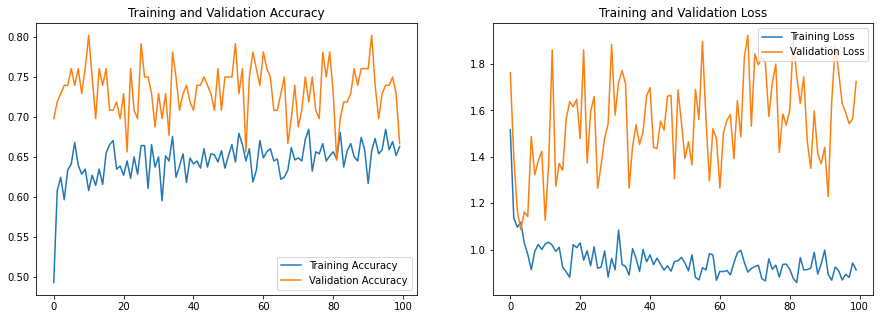

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

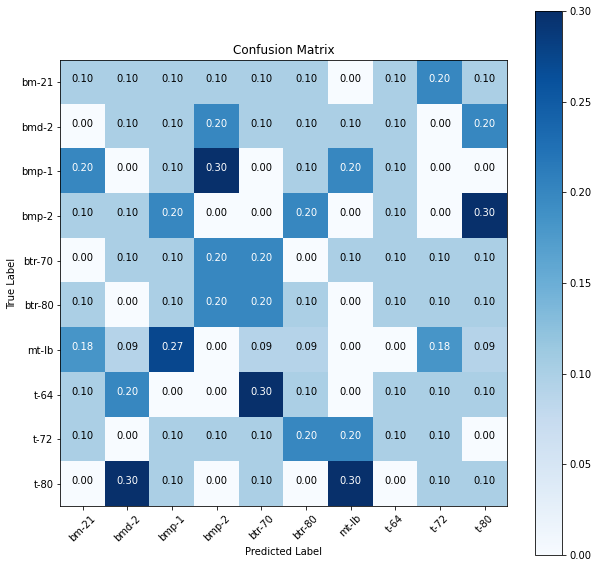

In [ ]:
test_pred = model.predict(test_generator)
y_pred = [np.argmax(probas) for probas in test_pred]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names)
plt.show()

In [ ]:
model.evaluate(test_generator)

7/7 [==============================] - 3s 316ms/step - loss: 1.6392 - accuracy: 0.7327


[1.6392269134521484, 0.7326732873916626]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.11      0.10      0.11        10
           1       0.10      0.10      0.10        10
           2       0.08      0.10      0.09        10
           3       0.00      0.00      0.00        10
           4       0.17      0.20      0.18        10
           5       0.10      0.10      0.10        10
           6       0.00      0.00      0.00        11
           7       0.12      0.10      0.11        10
           8       0.11      0.10      0.11        10
           9       0.09      0.10      0.10        10

    accuracy                           0.09       101
   macro avg       0.09      0.09      0.09       101
weighted avg       0.09      0.09      0.09       101



Smaller Dropout Layers

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with ResNet50 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    x = model_resnet.output
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x) 
    x = Dense(64, activation ='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation ='relu')(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_classes, activation='softmax')(x)
      
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in model_resnet.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in model_resnet.layers:
            layer.trainable = False

    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=model_resnet.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (224, 224, 3)
optim = RMSprop()
num_classes=10

# No layers unfrozen for Fine-Tuning
model = create_model(input_shape, num_classes, optim, fine_tune=0)

In [ ]:
K = tf.keras.backend

STEPS_PER_EPOCH = np.ceil(train_images.shape[0] / batch_size)
lr_finder = LRFinder(model)
lr_finder.find(train_generator, start_lr=1e-6, end_lr=1, epochs=50,
               steps_per_epoch=STEPS_PER_EPOCH)
               
learning_rates = lr_finder.get_learning_rates()
losses = lr_finder.get_losses()

best_lr = lr_finder.get_best_lr(sma=20)

# Setting it as our model's LR through Keras Backend
K.set_value(model.optimizer.lr, best_lr)
print("Best Learning Rate: ", best_lr)

Epoch 1/50
50/50 [==============================] - 23s 382ms/step - loss: 2.9933 - accuracy: 0.0989
Epoch 2/50
50/50 [==============================] - 19s 380ms/step - loss: 2.9436 - accuracy: 0.1114
Epoch 3/50
50/50 [==============================] - 19s 378ms/step - loss: 2.9635 - accuracy: 0.1014
Epoch 4/50
50/50 [==============================] - 19s 374ms/step - loss: 2.9586 - accuracy: 0.0989
Epoch 5/50
50/50 [==============================] - 19s 382ms/step - loss: 2.9979 - accuracy: 0.0839
Epoch 6/50
50/50 [==============================] - 19s 382ms/step - loss: 2.9291 - accuracy: 0.1064
Epoch 7/50
50/50 [==============================] - 19s 382ms/step - loss: 2.9204 - accuracy: 0.1014
Epoch 8/50
50/50 [==============================] - 19s 383ms/step - loss: 2.9109 - accuracy: 0.1202
Epoch 9/50
50/50 [==============================] - 19s 380ms/step - loss: 2.8494 - accuracy: 0.1126
Epoch 10/50
50/50 [==============================] - 19s 383ms/step - loss: 2.7821 - accura

In [ ]:
model.compile(optimizer=RMSprop(best_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 200

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    steps_per_epoch=train_images.shape[0] // batch_size,
                    validation_steps=val_images.shape[0] // batch_size,
                    verbose=1)

Epoch 1/200
49/49 [==============================] - 25s 437ms/step - loss: 2.8602 - accuracy: 0.0958 - val_loss: 2.3119 - val_accuracy: 0.0417
Epoch 2/200
49/49 [==============================] - 21s 421ms/step - loss: 2.7083 - accuracy: 0.1252 - val_loss: 2.2973 - val_accuracy: 0.0417
Epoch 3/200
49/49 [==============================] - 21s 419ms/step - loss: 2.3912 - accuracy: 0.2120 - val_loss: 2.2507 - val_accuracy: 0.0938
Epoch 4/200
49/49 [==============================] - 21s 421ms/step - loss: 2.2825 - accuracy: 0.2222 - val_loss: 2.1666 - val_accuracy: 0.1771
Epoch 5/200
49/49 [==============================] - 21s 423ms/step - loss: 2.0290 - accuracy: 0.3078 - val_loss: 2.0621 - val_accuracy: 0.2500
Epoch 6/200
49/49 [==============================] - 21s 421ms/step - loss: 1.8183 - accuracy: 0.3678 - val_loss: 1.9162 - val_accuracy: 0.4167
Epoch 7/200
49/49 [==============================] - 20s 415ms/step - loss: 1.6928 - accuracy: 0.4151 - val_loss: 1.7668 - val_accuracy:

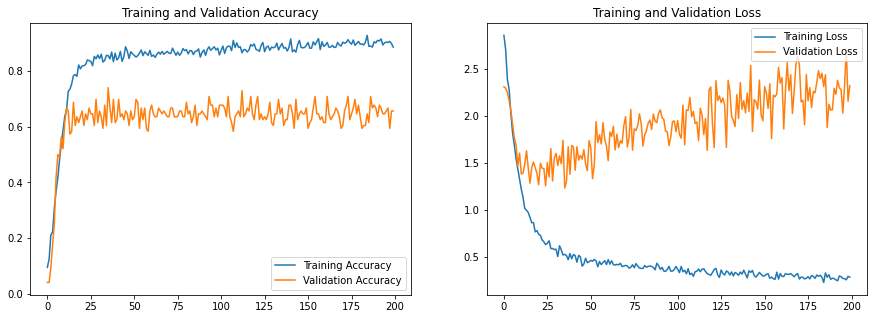

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

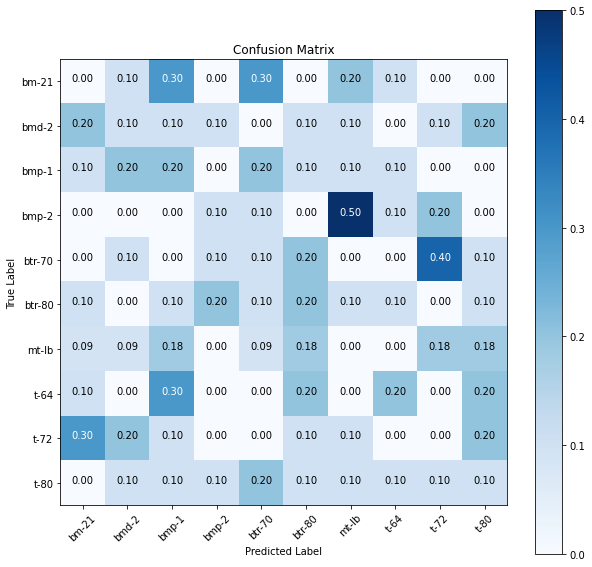

In [ ]:
test_pred = model.predict(test_generator)
y_pred = [np.argmax(probas) for probas in test_pred]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names)
plt.show()

In [ ]:
model.evaluate(test_generator)

7/7 [==============================] - 3s 416ms/step - loss: 2.3457 - accuracy: 0.6535


[2.3457090854644775, 0.6534653306007385]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.11      0.10      0.11        10
           2       0.14      0.20      0.17        10
           3       0.17      0.10      0.12        10
           4       0.09      0.10      0.10        10
           5       0.17      0.20      0.18        10
           6       0.00      0.00      0.00        11
           7       0.29      0.20      0.24        10
           8       0.00      0.00      0.00        10
           9       0.09      0.10      0.10        10

    accuracy                           0.10       101
   macro avg       0.11      0.10      0.10       101
weighted avg       0.10      0.10      0.10       101

